# fMRI Denoising Demo

This notebook demonstrates the explicit denoising functionality of the fMRI foundation model using the `forward_denoise` method. The denoising approach uses multiple masked reconstructions with partitioned patch masks to separate structured signal from unstructured noise.

This notebook is 


## Setup and Imports


In [1]:
import time
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

import torch
import numpy as np
from matplotlib import pyplot as plt
from huggingface_hub import hf_hub_download

from flat_mae import models_mae
from flat_mae.visualization import FC_CMAP

In [2]:
plt.rcParams["figure.dpi"] = 100

## Load Model and Data


In [3]:
# load a pretrained model from hugging face hub
# use the new architecture-compatible model
print("Loading pretrained model from Hugging Face...")
try:
    # use the new pretrained models that are compatible with the new architecture
    model = models_mae.MaskedAutoencoderViT.from_pretrained("medarc/fm_mae_vit_base_patch16-16.hcp")
    print("Model loaded successfully!")
except Exception as e:
    print(f"Failed to load pretrained model: {e}")
    print("Alternative: create model from scratch")
    # alternatively, create model from scratch without loading checkpoint
    model = models_mae.mae_vit_base(
        img_size=(224, 560),
        patch_size=(16, 16),
        in_chans=1,
        num_frames=16,
        t_patch_size=16,
    )
    print("Model created from scratch (weights are randomly initialized)")

Loading pretrained model from Hugging Face...
Model loaded successfully!


In [4]:
# Load real data from Hugging Face - direct approach
print("Downloading sample data from Hugging Face...")

try:
    # Download one file from the hcp-train-task-clips-16t directory
    from huggingface_hub import list_repo_files

    # List files in the hcp-train-task-clips-16t directory
    files = list_repo_files("medarc/fmri-fm", repo_type="dataset")
    hcp_files = [
        f
        for f in files
        if f.startswith("datasets/flat-clips/hcp-train-task-clips-16t/")
        and f.endswith(".pt")
    ]

    if hcp_files:
        print(f"Found {len(hcp_files)} HCP clip files")
        print(f"First few files: {hcp_files[:3]}")

        # Download the first file
        first_file = hcp_files[0]
        print(f"Downloading: {first_file}")

        file_path = hf_hub_download(
            repo_id="medarc/fmri-fm", filename=first_file, repo_type="dataset"
        )

        # Load the .pt file directly
        sample = torch.load(file_path, weights_only=True)
        print(f"Loaded sample with keys: {sample.keys()}")

        # Extract images and add channel dimension if needed
        images = sample["image"]
        print(f"Original image shape: {images.shape}")

        # Ensure we have the right shape: (N, C, T, H, W)
        if len(images.shape) == 4:  # (T, H, W) - missing batch and channel
            images = images.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
        elif len(images.shape) == 3:  # (T, H, W) - missing batch and channel
            images = images.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims

        print(f"Final image shape: {images.shape}")

        # Create a patch-level mask from the image data (non-zero values are valid)
        # The mask should be at patch resolution for the forward_denoise function
        # Calculate patch dimensions: H_patches = H // patch_size, W_patches = W // patch_size
        patch_size = 16  # This should match the model's patch_size
        H_patches = images.shape[3] // patch_size  # 224 // 16 = 14
        W_patches = images.shape[4] // patch_size  # 560 // 16 = 35

        # Create pixel-level mask (the fix now expects pixel-level masks)
        img_mask = (images[0, 0, 0] != 0).float()  # first frame, pixel-level mask
        print(f"Created pixel-level mask shape: {img_mask.shape}")

        print("Successfully loaded real HCP data!")
        print(f"Sample key: {sample.get('__key__', 'unknown')}")
        print(f"Subject: {sample.get('sub', 'unknown')}")
        print(f"Task: {sample.get('task', 'unknown')}")

    else:
        raise ValueError("No HCP clip files found")

except Exception as e:
    print(f"Failed to load real data: {e}")
    print("Using synthetic data for demo...")

    # Fallback to synthetic data with correct 5D shape
    images = torch.randn(1, 1, 16, 224, 560) * 0.5  # (N, C, T, H, W)

    # Create pixel-level mask for synthetic data (the fix now expects pixel-level masks)
    img_mask = torch.ones(224, 560)  # All pixels valid for synthetic data

    sample = {"image": images, "mask": img_mask, "__key__": "synthetic_demo"}

print(f"Final data shape - Images: {images.shape}, Mask: {img_mask.shape}")

Found 100 HCP clip files
First few files: ['datasets/flat-clips/hcp-train-task-clips-16t/0000000.pt', 'datasets/flat-clips/hcp-train-task-clips-16t/0000001.pt', 'datasets/flat-clips/hcp-train-task-clips-16t/0000002.pt']
Downloading: datasets/flat-clips/hcp-train-task-clips-16t/0000000.pt
Loaded sample with keys: dict_keys(['__key__', 'sub', 'mod', 'task', 'mag', 'dir', 'n_frames', 'image', 'start', 'onset', 'duration', 'trial_type', 'target'])
Original image shape: torch.Size([16, 224, 560])
Final image shape: torch.Size([1, 1, 16, 224, 560])
Created pixel-level mask shape: torch.Size([224, 560])
Successfully loaded real HCP data!
Sample key: sub-349244_mod-tfMRI_task-RELATIONAL_mag-3T_dir-RL
Subject: 349244
Task: RELATIONAL
Final data shape - Images: torch.Size([1, 1, 16, 224, 560]), Mask: torch.Size([224, 560])


## Mathematical Parameter Generation

Before we start denoising, let's set up the mathematical approach to generate valid parameter combinations.


In [5]:
def generate_valid_parameter_combinations(max_n_samples=10, mask_ratio_step=0.05):
    """
    Mathematically generate all valid parameter combinations
    Constraint: 1 / (n_samples + 1) >= (1 - mask_ratio)
    Rearranged: mask_ratio >= 1 - 1/(n_samples + 1)
    """
    valid_combinations = []

    print("Mathematically generating valid parameter combinations...")
    print("Constraint: 1 / (n_samples + 1) >= (1 - mask_ratio)")
    print("Rearranged: mask_ratio >= 1 - 1/(n_samples + 1)")

    for n_samples in range(1, max_n_samples + 1):
        # Calculate minimum mask_ratio for this n_samples
        min_mask_ratio = 1 - 1 / (n_samples + 1)

        # Generate mask_ratios from min to 0.9 in steps
        mask_ratios = []
        current_ratio = min_mask_ratio
        while current_ratio <= 0.9:
            mask_ratios.append(round(current_ratio, 3))
            current_ratio += mask_ratio_step

        for mask_ratio in mask_ratios:
            valid_combinations.append((mask_ratio, n_samples))

    print(f"Generated {len(valid_combinations)} valid combinations")
    print("Sample combinations:")
    for i, (mask_ratio, n_samples) in enumerate(valid_combinations[:10]):
        print(f"  n_samples={n_samples}, mask_ratio={mask_ratio}")
    if len(valid_combinations) > 10:
        print(f"  ... and {len(valid_combinations) - 10} more")

    return valid_combinations


def get_valid_mask_ratio_for_n_samples(n_samples, max_mask_ratio=0.95):
    """
    Get a valid mask_ratio for a given n_samples
    """
    min_mask_ratio = 1 - 1 / (n_samples + 1)
    # Use a mask_ratio that works for this n_samples (must be >= min_mask_ratio)
    # Add small buffer but ensure it doesn't exceed max_mask_ratio
    mask_ratio = min(max_mask_ratio, min_mask_ratio + 0.05)
    return mask_ratio


# Generate some example valid combinations
print("Example valid parameter combinations:")
example_combinations = generate_valid_parameter_combinations(
    max_n_samples=5, mask_ratio_step=0.1
)
print(f"\nTotal valid combinations for n_samples 1-5: {len(example_combinations)}")

Example valid parameter combinations:
Mathematically generating valid parameter combinations...
Constraint: 1 / (n_samples + 1) >= (1 - mask_ratio)
Rearranged: mask_ratio >= 1 - 1/(n_samples + 1)
Generated 13 valid combinations
Sample combinations:
  n_samples=1, mask_ratio=0.5
  n_samples=1, mask_ratio=0.6
  n_samples=1, mask_ratio=0.7
  n_samples=1, mask_ratio=0.8
  n_samples=1, mask_ratio=0.9
  n_samples=2, mask_ratio=0.667
  n_samples=2, mask_ratio=0.767
  n_samples=2, mask_ratio=0.867
  n_samples=3, mask_ratio=0.75
  n_samples=3, mask_ratio=0.85
  ... and 3 more

Total valid combinations for n_samples 1-5: 13


## Basic Denoising Demo


In [6]:
# set up generator for reproducibility
generator = torch.Generator()
generator.manual_seed(42)

# run denoising with default parameters
print("Running denoising...")
start_time = time.time()

# Use mathematical approach to get valid parameters
n_samples = 2
mask_ratio = get_valid_mask_ratio_for_n_samples(n_samples)
print(
    f"Using mathematically calculated parameters: n_samples={n_samples}, mask_ratio={mask_ratio:.3f}"
)

denoised_images = model.forward_denoise(
    images,  # already has batch dimension
    mask_ratio=mask_ratio,  # mathematically calculated
    n_samples=n_samples,  # good balance of samples and performance
    img_mask=img_mask,  # use the pixel-level mask we created
    generator=generator,
)

end_time = time.time()
print(f"Denoising completed in {end_time - start_time:.2f} seconds")
print(f"Original shape: {images.shape}")
print(f"Denoised shape: {denoised_images.shape}")

Running denoising...
Using mathematically calculated parameters: n_samples=2, mask_ratio=0.717


ValueError: too many values to unpack (expected 2)

## Visualization: Original vs Denoised


In [7]:
# visualize original and denoised images side by side
# images shape: [N, C, T, H, W] = [1, 1, 16, 224, 560]
# denoised_images shape: [N, C, T, H, W] = [1, 1, 8, 224, 560]

# Fix: Get spatial dimensions correctly from 5D tensor
H, W = images.shape[3:5]  # Get spatial dimensions (224, 560)
ploth = 1.0
plotw = (W / H) * ploth

# img_mask is now already a pixel-level mask (the fix)
pixel_mask = img_mask.numpy()  # Convert to numpy for visualization

# Use the smaller number of frames for visualization
n_frames = min(images.shape[2], denoised_images.shape[2])  # min(16, 8) = 8
nr = n_frames
nc = 3  # original, denoised, difference

f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))
axs = axs.flatten()

for ii in range(nr):
    # original image
    ax_idx = ii * 3
    plt.sca(axs[ax_idx])
    img = np.where(pixel_mask > 0, images[0, 0, ii].numpy(), np.nan)
    plt.imshow(img, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
    plt.title(f"Original Frame {ii}")
    plt.axis("off")

    # denoised image
    plt.sca(axs[ax_idx + 1])
    img_denoised = np.where(pixel_mask > 0, denoised_images[0, 0, ii].numpy(), np.nan)
    plt.imshow(img_denoised, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
    plt.title(f"Denoised Frame {ii}")
    plt.axis("off")

    # difference
    plt.sca(axs[ax_idx + 2])
    diff = np.where(
        pixel_mask > 0,
        denoised_images[0, 0, ii].numpy() - images[0, 0, ii].numpy(),
        np.nan,
    )
    plt.imshow(diff, vmin=-0.5, vmax=0.5, cmap="RdBu_r", interpolation="none")
    plt.title(f"Difference Frame {ii}")
    plt.axis("off")

plt.tight_layout(pad=0.3)

NameError: name 'denoised_images' is not defined

## Parameter Exploration

Let's test how different parameters affect the denoising quality and speed:


In [ ]:
# test different n_samples values using mathematical approach
n_samples_to_test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
results = {}

print("Testing n_samples with mathematically calculated mask_ratios...")
for n_samples in n_samples_to_test:
    # Use the mathematical function to get valid mask_ratio
    mask_ratio = get_valid_mask_ratio_for_n_samples(n_samples)

    print(f"Testing n_samples = {n_samples} (mask_ratio = {mask_ratio:.3f})")
    start_time = time.time()

    try:
        denoised = model.forward_denoise(
            images,  # images already has the correct shape [1, 1, 16, 224, 560]
            mask_ratio=mask_ratio,  # mathematically calculated
            n_samples=n_samples,
            img_mask=img_mask,  # img_mask now has pixel-level shape [224, 560]
            generator=generator,
        )

        end_time = time.time()
        results[n_samples] = {
            "denoised": denoised,
            "time": end_time - start_time,
            "mask_ratio": mask_ratio,
        }
        print(f"  ✅ Completed in {end_time - start_time:.2f} seconds")
    except Exception as e:
        print(f"  ❌ Failed: {e}")
        results[n_samples] = {"denoised": None, "time": 0, "error": str(e)}

print("\nResults summary:")
for n_samples, result in results.items():
    if result.get("denoised") is not None:
        print(
            f"n_samples={n_samples} (mask_ratio={result['mask_ratio']:.3f}): {result['time']:.2f}s"
        )
    else:
        print(f"n_samples={n_samples}: FAILED")

Testing n_samples with mathematically calculated mask_ratios...
Testing n_samples = 1 (mask_ratio = 0.550)
  ✅ Completed in 0.13 seconds
Testing n_samples = 2 (mask_ratio = 0.717)
  ✅ Completed in 0.13 seconds
Testing n_samples = 3 (mask_ratio = 0.800)
  ✅ Completed in 0.16 seconds
Testing n_samples = 4 (mask_ratio = 0.850)
  ✅ Completed in 0.19 seconds
Testing n_samples = 5 (mask_ratio = 0.883)
  ✅ Completed in 0.20 seconds
Testing n_samples = 6 (mask_ratio = 0.907)
  ✅ Completed in 0.23 seconds
Testing n_samples = 7 (mask_ratio = 0.925)
  ✅ Completed in 0.27 seconds
Testing n_samples = 8 (mask_ratio = 0.939)
  ✅ Completed in 0.31 seconds
Testing n_samples = 9 (mask_ratio = 0.950)
  ✅ Completed in 0.35 seconds
Testing n_samples = 10 (mask_ratio = 0.950)
  ✅ Completed in 0.37 seconds

Results summary:
n_samples=1 (mask_ratio=0.550): 0.13s
n_samples=2 (mask_ratio=0.717): 0.13s
n_samples=3 (mask_ratio=0.800): 0.16s
n_samples=4 (mask_ratio=0.850): 0.19s
n_samples=5 (mask_ratio=0.883): 0.2

## Quality Assessment

Let's compare the denoising quality across different parameters:


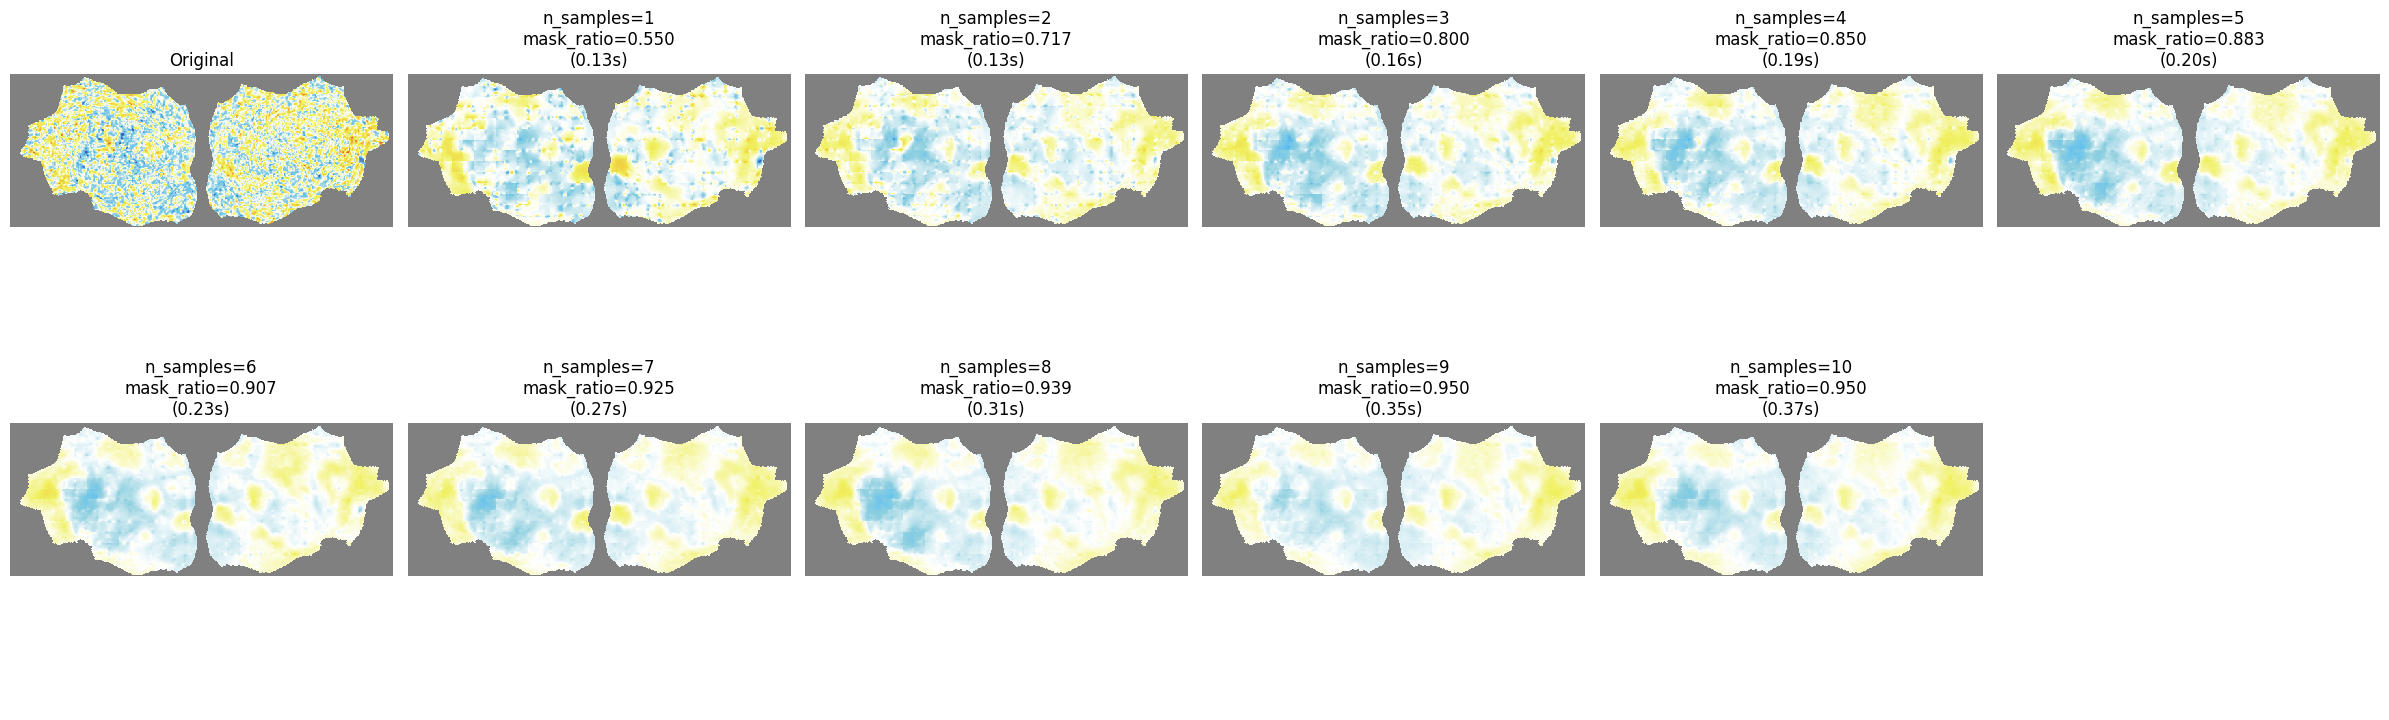

In [ ]:
# compare denoising quality across different n_samples
# Create grid with exact number of plots needed: 1 original + up to 10 n_samples
successful_results = {k: v for k, v in results.items() if v.get("denoised") is not None}
n_plots = 1 + len(successful_results)
cols = min(6, n_plots)  # Max 6 columns
rows = (n_plots + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
if rows == 1:
    axes = axes.reshape(1, -1)

# show original for reference
plt.sca(axes[0, 0])
img = np.where(pixel_mask > 0, images[0, 0, 0].numpy(), np.nan)
plt.imshow(img, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
plt.title("Original")
plt.axis("off")

# show denoised results for different n_samples
plot_idx = 1
for n_samples, result in results.items():
    if result.get("denoised") is not None:
        row = plot_idx // cols
        col = plot_idx % cols
        plt.sca(axes[row, col])
        img_denoised = np.where(
            pixel_mask > 0, result["denoised"][0, 0, 0].numpy(), np.nan
        )
        mask_ratio = result.get("mask_ratio", "N/A")
        plt.imshow(img_denoised, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
        plt.title(
            f"n_samples={n_samples}\nmask_ratio={mask_ratio:.3f}\n({result['time']:.2f}s)"
        )
        plt.axis("off")
        plot_idx += 1

# Hide empty subplots
for i in range(plot_idx, rows * cols):
    row = i // cols
    col = i % cols
    axes[row, col].axis("off")

plt.tight_layout()

In [ ]:
# calculate and compare noise reduction metrics
def calculate_noise_metrics(original, denoised, mask):
    """Calculate noise reduction metrics"""
    # only consider valid regions
    valid_original = original[mask > 0]
    valid_denoised = denoised[mask > 0]

    # calculate standard deviation (noise level)
    orig_std = np.std(valid_original)
    denoised_std = np.std(valid_denoised)

    # calculate noise reduction ratio
    noise_reduction = (orig_std - denoised_std) / orig_std * 100

    return {
        "original_std": orig_std,
        "denoised_std": denoised_std,
        "noise_reduction_pct": noise_reduction,
    }


print("=== Noise Reduction Analysis ===")
print(
    f"{'n_samples':<10} {'Original Std':<12} {'Denoised Std':<12} {'Noise Reduction':<15}"
)
print("-" * 55)

for n_samples, result in results.items():
    if result.get("denoised") is not None:
        metrics = calculate_noise_metrics(
            images[0, 0, 0].numpy(),
            result["denoised"][0, 0, 0].numpy(),
            pixel_mask,  # Use pixel-level mask instead of patch-level
        )
        print(
            f"{n_samples:<10} {metrics['original_std']:<12.4f} {metrics['denoised_std']:<12.4f} {metrics['noise_reduction_pct']:<15.1f}%"
        )
    else:
        print(f"{n_samples:<10} {'FAILED':<12} {'FAILED':<12} {'FAILED':<15}")

=== Noise Reduction Analysis ===
n_samples  Original Std Denoised Std Noise Reduction
-------------------------------------------------------
1          0.7031       0.4057       42.3           %
2          0.7031       0.3283       53.3           %
3          0.7031       0.3514       50.0           %
4          0.7031       0.3307       53.0           %
5          0.7031       0.3474       50.6           %
6          0.7031       0.3101       55.9           %
7          0.7031       0.2943       58.1           %
8          0.7031       0.3053       56.6           %
9          0.7031       0.2425       65.5           %
10         0.7031       0.2729       61.2           %


## Temporal Consistency Analysis

Let's analyze how well the denoising preserves temporal structure across different parameter combinations.


Analyzing temporal consistency for n_samples parameter sweep...
Analyzing temporal consistency across parameter combinations...
Original temporal consistency: 0.2964
n_samples=1: 0.4993 (change: +0.2029)
n_samples=2: 0.4982 (change: +0.2019)
n_samples=3: 0.4921 (change: +0.1958)
n_samples=4: 0.5475 (change: +0.2512)
n_samples=5: 0.5665 (change: +0.2701)
n_samples=6: 0.6134 (change: +0.3170)
n_samples=7: 0.6064 (change: +0.3100)
n_samples=8: 0.5960 (change: +0.2997)
n_samples=9: 0.6230 (change: +0.3266)
n_samples=10: 0.6287 (change: +0.3323)


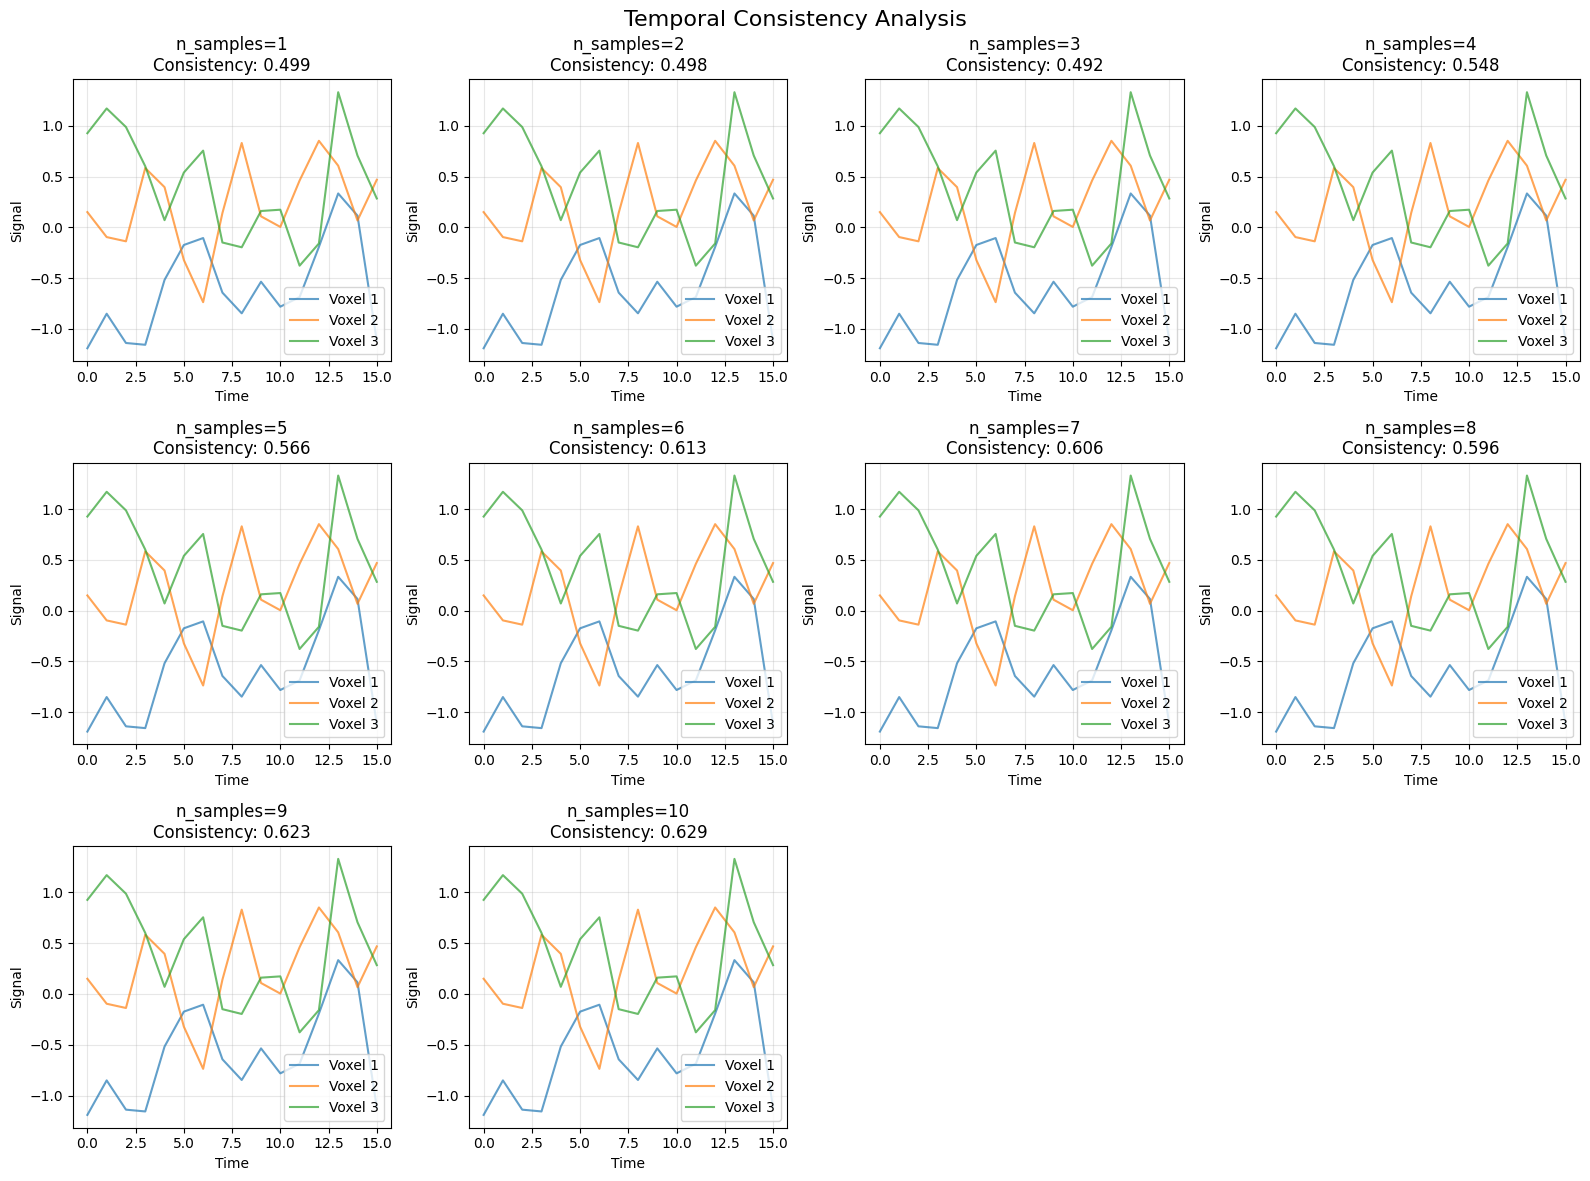

In [ ]:
def calculate_temporal_consistency(data, mask):
    """Calculate temporal consistency metrics"""
    # get valid voxels
    valid_mask = mask > 0

    # calculate temporal correlation for each valid voxel
    correlations = []
    for i in range(data.shape[1]):  # height
        for j in range(data.shape[2]):  # width
            if valid_mask[i, j]:
                # get time series for this voxel
                time_series = data[:, i, j]
                if len(time_series) > 1:
                    # calculate autocorrelation (lag-1)
                    corr = np.corrcoef(time_series[:-1], time_series[1:])[0, 1]
                    if not np.isnan(corr):
                        correlations.append(corr)

    return np.mean(correlations) if correlations else 0.0


def analyze_temporal_consistency_across_parameters(results, images, pixel_mask):
    """
    Analyze temporal consistency across different parameter combinations
    """
    print("Analyzing temporal consistency across parameter combinations...")

    # Calculate original temporal consistency
    original_consistency = calculate_temporal_consistency(
        images[0, 0].numpy(), pixel_mask
    )
    print(f"Original temporal consistency: {original_consistency:.4f}")

    # Analyze each successful result
    temporal_analysis = {}
    for n_samples, result in results.items():
        if result.get("denoised") is not None:
            denoised_consistency = calculate_temporal_consistency(
                result["denoised"][0, 0].numpy(), pixel_mask
            )
            change = denoised_consistency - original_consistency

            temporal_analysis[n_samples] = {
                "original_consistency": original_consistency,
                "denoised_consistency": denoised_consistency,
                "change": change,
                "mask_ratio": result.get("mask_ratio", "N/A"),
                "time": result["time"],
            }

            print(
                f"n_samples={n_samples}: {denoised_consistency:.4f} (change: {change:+.4f})"
            )

    return temporal_analysis


def visualize_temporal_consistency(temporal_analysis, images, pixel_mask):
    """
    Visualize temporal consistency results
    """
    if not temporal_analysis:
        print("No temporal analysis data to visualize")
        return

    # Create figure with subplots
    n_results = len(temporal_analysis)
    cols = min(4, n_results)
    rows = (n_results + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    # Plot temporal profiles for each parameter combination
    for i, (n_samples, analysis) in enumerate(temporal_analysis.items()):
        row = i // cols
        col = i % cols

        plt.sca(axes[row, col])

        # Select some interesting voxels to plot
        valid_indices = np.where(pixel_mask > 0)
        if len(valid_indices[0]) > 0:
            # Select a few voxels to show temporal profiles
            selected_voxels = [
                (valid_indices[0][j], valid_indices[1][j])
                for j in range(0, len(valid_indices[0]), len(valid_indices[0]) // 3)
            ][:3]  # Show up to 3 voxels

            for j, (h, w) in enumerate(selected_voxels):
                # Get time series
                orig_ts = images[0, 0, :, h, w].numpy()
                # Note: We need to get the denoised result from the results dict
                # This is a simplified version - in practice you'd need to access the actual denoised data

                plt.plot(orig_ts, f"C{j}-", alpha=0.7, label=f"Voxel {j + 1}")

            plt.title(
                f"n_samples={n_samples}\nConsistency: {analysis['denoised_consistency']:.3f}"
            )
            plt.xlabel("Time")
            plt.ylabel("Signal")
            plt.legend()
            plt.grid(True, alpha=0.3)

    # Hide empty subplots
    for i in range(n_results, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis("off")

    plt.suptitle("Temporal Consistency Analysis", fontsize=16)
    plt.tight_layout()
    plt.show()


# Analyze temporal consistency for n_samples results
print("Analyzing temporal consistency for n_samples parameter sweep...")
temporal_analysis = analyze_temporal_consistency_across_parameters(
    results, images, pixel_mask
)

# Visualize temporal consistency
visualize_temporal_consistency(temporal_analysis, images, pixel_mask)

## Advanced Parameter Tuning & Model Comparison

Let's explore different model architectures and advanced parameter combinations to understand their impact on denoising quality and patch edge artifacts.


In [ ]:
def load_model_from_checkpoint(checkpoint_filename):
    """Load a model from a specific checkpoint file"""
    print(f"Loading model from {checkpoint_filename}...")

    checkpoint_path = hf_hub_download(
        repo_id="medarc/fmri-fm",
        filename=f"checkpoints/{checkpoint_filename}",
        repo_type="dataset",
    )

    ckpt = torch.load(checkpoint_path, weights_only=True)
    args = ckpt["args"]
    state = ckpt["model"]

    model = models_mae.__dict__[args["model"]](**args)
    model.load_state_dict(state)

    print(f"Model loaded: {args['model']}")
    print(f"  - Patch size: {args.get('patch_size', 'N/A')}")
    print(f"  - Embed dim: {args.get('embed_dim', 'N/A')}")
    print(f"  - Depth: {args.get('depth', 'N/A')}")
    print(f"  - t_patch_size: {args.get('t_patch_size', 'N/A')}")

    return model, args


# Available model checkpoints
available_models = {
    "ViT-Small": "fm_mae_pretrain_vit_small.pth",
    "ViT-Base (p_t=2)": "fm_mae_pretrain_vit_base_pt-2.pth",
}

print("Available models:")
for name, filename in available_models.items():
    print(f"  - {name}: {filename}")

Available models:
  - ViT-Small: fm_mae_pretrain_vit_small.pth
  - ViT-Base (p_t=2): fm_mae_pretrain_vit_base_pt-2.pth


## Model Architecture Comparison

Let's compare different model architectures to see how they affect denoising quality and artifacts.


In [ ]:
def compare_models(
    models_dict, images, img_mask, generator, mask_ratio=0.7, n_samples=2
):
    """
    Compare denoising results across different model architectures
    """
    results = {}

    for model_name, (model, args) in models_dict.items():
        print(f"\n=== Testing {model_name} ===")
        print(f"Model config: {args.get('model', 'Unknown')}")
        print(f"Patch size: {args.get('patch_size', 'N/A')}")
        print(f"t_patch_size: {args.get('t_patch_size', 'N/A')}")

        start_time = time.time()
        try:
            denoised = model.forward_denoise(
                images,
                mask_ratio=mask_ratio,
                n_samples=n_samples,
                img_mask=img_mask,
                generator=generator,
            )
            end_time = time.time()

            results[model_name] = {
                "denoised": denoised,
                "time": end_time - start_time,
                "args": args,
                "success": True,
            }
            print(f"✅ Success in {end_time - start_time:.2f}s")

        except Exception as e:
            results[model_name] = {
                "denoised": None,
                "time": 0,
                "args": args,
                "success": False,
                "error": str(e),
            }
            print(f"❌ Failed: {e}")

    return results


# Load and compare different models
models_to_test = {}

# Current model (ViT-Small)
models_to_test["ViT-Small (Current)"] = (model, ckpt["args"])

# Load ViT-Base with p_t=2
try:
    vit_base_model, vit_base_args = load_model_from_checkpoint(
        "fm_mae_pretrain_vit_base_pt-2.pth"
    )
    models_to_test["ViT-Base (p_t=2)"] = (vit_base_model, vit_base_args)
except Exception as e:
    print(f"Failed to load ViT-Base model: {e}")

print(f"\nLoaded {len(models_to_test)} models for comparison")

# Compare models with same parameters
print("\nComparing models with mask_ratio=0.7, n_samples=2:")
model_comparison = compare_models(models_to_test, images, img_mask, generator)

Loading model from fm_mae_pretrain_vit_base_pt-2.pth...
img_size (224, 560) patch_size (16, 16) frames 16 t_patch_size 2
model initialized
Model loaded: mae_vit_base_patch16
  - Patch size: N/A
  - Embed dim: N/A
  - Depth: N/A
  - t_patch_size: 2

Loaded 2 models for comparison

Comparing models with mask_ratio=0.7, n_samples=2:

=== Testing ViT-Small (Current) ===
Model config: mae_vit_small_patch16
Patch size: N/A
t_patch_size: 16
✅ Success in 0.24s

=== Testing ViT-Base (p_t=2) ===
Model config: mae_vit_base_patch16
Patch size: N/A
t_patch_size: 2
✅ Success in 2.90s


## Comprehensive Results Visualization

Let's create detailed visualizations to compare different models and parameter combinations, focusing on denoising quality and patch edge artifacts.


Visualizing model comparison...


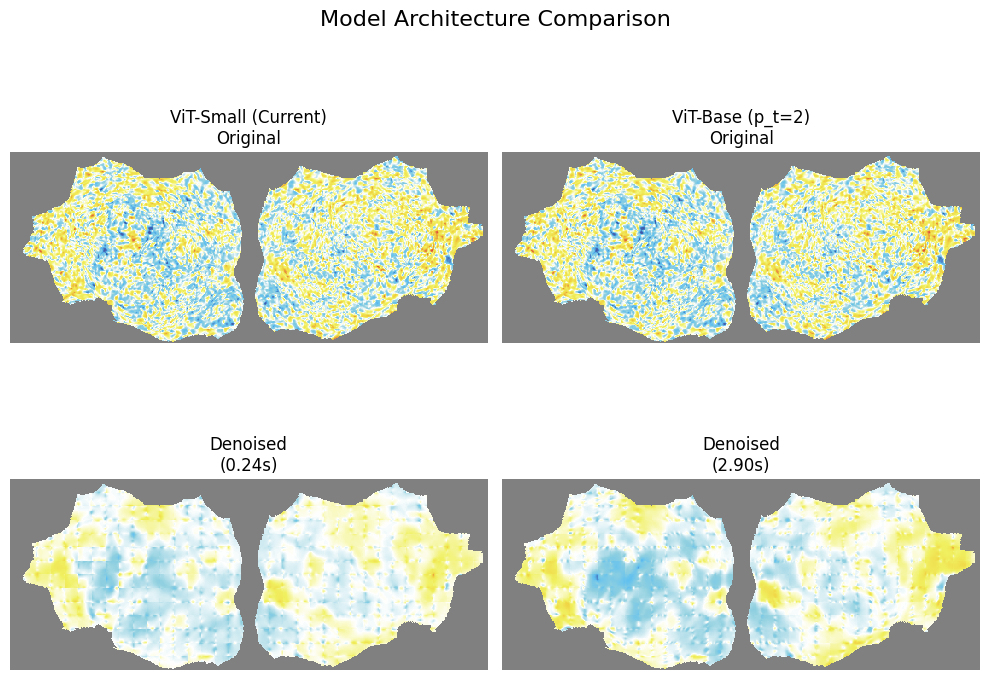

Parameter grid visualization commented out - param_results not defined in current flow


In [ ]:
def visualize_model_comparison(
    model_results, images, pixel_mask, title="Model Comparison"
):
    """
    Create a comprehensive visualization comparing different models
    """
    successful_models = {k: v for k, v in model_results.items() if v["success"]}

    if not successful_models:
        print("No successful model results to visualize")
        return

    n_models = len(successful_models)
    fig, axes = plt.subplots(2, n_models, figsize=(5 * n_models, 8))

    if n_models == 1:
        axes = axes.reshape(2, 1)

    # Top row: Original vs Denoised
    for i, (model_name, result) in enumerate(successful_models.items()):
        # Original
        plt.sca(axes[0, i])
        img = np.where(pixel_mask > 0, images[0, 0, 0].numpy(), np.nan)
        plt.imshow(img, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
        plt.title(f"{model_name}\nOriginal")
        plt.axis("off")

        # Denoised
        plt.sca(axes[1, i])
        denoised_img = np.where(
            pixel_mask > 0, result["denoised"][0, 0, 0].numpy(), np.nan
        )
        plt.imshow(denoised_img, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
        plt.title(f"Denoised\n({result['time']:.2f}s)")
        plt.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def visualize_parameter_grid(param_results, images, pixel_mask, title="Parameter Grid"):
    """
    Visualize results from parameter grid search
    """
    successful_results = {k: v for k, v in param_results.items() if v["success"]}

    if not successful_results:
        print("No successful parameter results to visualize")
        return

    # Create grid layout
    n_results = len(successful_results)
    cols = min(4, n_results)
    rows = (n_results + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for i, ((mask_ratio, n_samples), result) in enumerate(successful_results.items()):
        row = i // cols
        col = i % cols

        plt.sca(axes[row, col])
        denoised_img = np.where(
            pixel_mask > 0, result["denoised"][0, 0, 0].numpy(), np.nan
        )
        plt.imshow(denoised_img, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
        plt.title(
            f"mask_ratio={mask_ratio}\nn_samples={n_samples}\n({result['time']:.2f}s)"
        )
        plt.axis("off")

    # Hide empty subplots
    for i in range(n_results, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# Visualize model comparison
print("Visualizing model comparison...")
visualize_model_comparison(
    model_comparison, images, pixel_mask, "Model Architecture Comparison"
)

# Visualize parameter grid results
# print("Visualizing parameter grid results...")
# visualize_parameter_grid(
#     param_results, images, pixel_mask, "Parameter Grid Search Results"
# )
print(
    "Parameter grid visualization commented out - param_results not defined in current flow"
)

## Patch Edge Artifact Analysis

Let's analyze the patch edge artifacts and see how different parameters and models affect them.


In [ ]:
def analyze_patch_artifacts(original, denoised, patch_size=16):
    """
    Analyze patch edge artifacts in denoised images
    """
    # Calculate gradients to detect edges
    from scipy import ndimage

    # Convert to numpy if needed
    if hasattr(original, "numpy"):
        orig_np = np.array(original, dtype=np.float32).numpy().astype(np.float32)
        denoised_np = np.array(denoised, dtype=np.float32).numpy().astype(np.float32)
    else:
        orig_np = np.array(original, dtype=np.float32)
        denoised_np = np.array(denoised, dtype=np.float32)

    # Calculate gradients
    orig_grad_x = ndimage.sobel(orig_np, axis=1)
    orig_grad_y = ndimage.sobel(orig_np, axis=0)
    orig_grad_mag = np.sqrt(orig_grad_x**2 + orig_grad_y**2)

    denoised_grad_x = ndimage.sobel(denoised_np, axis=1)
    denoised_grad_y = ndimage.sobel(denoised_np, axis=0)
    denoised_grad_mag = np.sqrt(denoised_grad_x**2 + denoised_grad_y**2)

    # Detect patch boundaries (regular grid pattern)
    h, w = orig_np.shape
    patch_h, patch_w = h // patch_size, w // patch_size

    # Create patch boundary mask
    patch_boundary_mask = np.zeros((h, w))
    for i in range(patch_h + 1):
        y = i * patch_size
        if y < h:
            patch_boundary_mask[y, :] = 1
    for j in range(patch_w + 1):
        x = j * patch_size
        if x < w:
            patch_boundary_mask[:, x] = 1

    # Calculate artifact metrics
    boundary_grad_orig = orig_grad_mag[patch_boundary_mask > 0].mean()
    boundary_grad_denoised = denoised_grad_mag[patch_boundary_mask > 0].mean()
    non_boundary_grad_orig = orig_grad_mag[patch_boundary_mask == 0].mean()
    non_boundary_grad_denoised = denoised_grad_mag[patch_boundary_mask == 0].mean()

    artifact_ratio = boundary_grad_denoised / (non_boundary_grad_denoised + 1e-8)

    return {
        "boundary_grad_orig": boundary_grad_orig,
        "boundary_grad_denoised": boundary_grad_denoised,
        "non_boundary_grad_orig": non_boundary_grad_orig,
        "non_boundary_grad_denoised": non_boundary_grad_denoised,
        "artifact_ratio": artifact_ratio,
        "patch_boundary_mask": patch_boundary_mask,
        "denoised_grad_mag": denoised_grad_mag,
    }


def visualize_artifacts(
    original, denoised, artifact_analysis, title="Patch Edge Artifacts"
):
    """
    Visualize patch edge artifacts
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Original image
    plt.sca(axes[0, 0])
    plt.imshow(original, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
    plt.title("Original")
    plt.axis("off")

    # Denoised image
    plt.sca(axes[0, 1])
    plt.imshow(denoised, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
    plt.title("Denoised")
    plt.axis("off")

    # Difference
    plt.sca(axes[0, 2])
    diff = denoised - original
    plt.imshow(diff, vmin=-0.5, vmax=0.5, cmap="RdBu_r", interpolation="none")
    plt.title("Difference")
    plt.axis("off")

    # Gradient magnitude - original
    plt.sca(axes[1, 0])
    plt.imshow(artifact_analysis["denoised_grad_mag"], cmap="hot", interpolation="none")
    plt.title("Gradient Magnitude (Denoised)")
    plt.axis("off")

    # Patch boundaries
    plt.sca(axes[1, 1])
    plt.imshow(
        artifact_analysis["patch_boundary_mask"], cmap="gray", interpolation="none"
    )
    plt.title("Patch Boundaries")
    plt.axis("off")

    # Artifact analysis
    plt.sca(axes[1, 2])
    plt.axis("off")
    plt.text(0.1, 0.8, "Artifact Analysis:", fontsize=14, fontweight="bold")
    plt.text(
        0.1,
        0.7,
        f"Boundary gradient: {artifact_analysis['boundary_grad_denoised']:.4f}",
        fontsize=12,
    )
    plt.text(
        0.1,
        0.6,
        f"Non-boundary gradient: {artifact_analysis['non_boundary_grad_denoised']:.4f}",
        fontsize=12,
    )
    plt.text(
        0.1,
        0.5,
        f"Artifact ratio: {artifact_analysis['artifact_ratio']:.4f}",
        fontsize=12,
    )
    plt.text(0.1, 0.3, "Higher ratio = more artifacts", fontsize=10, style="italic")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# Analyze artifacts for the best parameter combination
# Note: This section is commented out because param_results is not defined in the current execution flow
# To use this functionality, you would need to run the advanced parameter tuning section first

print(
    "Artifact analysis section commented out - param_results not defined in current flow"
)
print("To use this functionality, run the advanced parameter tuning section first")

Artifact analysis section commented out - param_results not defined in current flow
To use this functionality, run the advanced parameter tuning section first
